# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

with open('train.p', mode='rb') as f:
    train = pickle.load(f)
with open('test.p', mode='rb') as f:
    test = pickle.load(f)
    
X_train_orig, y_train_orig = train['features'], train['labels']
X_test_orig, y_test_orig = test['features'], test['labels']
print('training and testing data loaded')

training and testing data loaded


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
n_train = len(X_train_orig)
n_test = len(X_test_orig)
image_shape = X_train_orig[0].shape
n_classes = len(set(y_train_orig))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

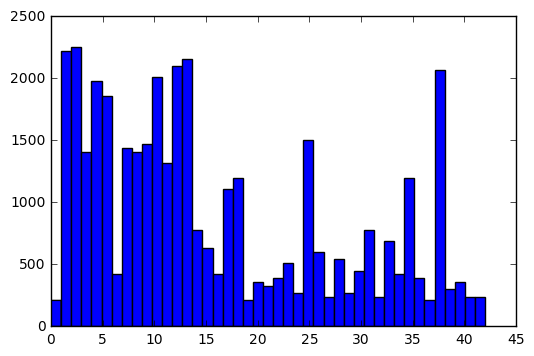

display image no 32380, label: 31


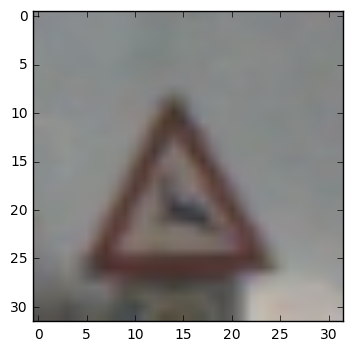

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random

%matplotlib inline

def show_labels_histogram(labels):
    bins = len(set(labels))
    plt.hist(labels, bins=bins)
    plt.show()
    

def display_image(img_data):
    plt.imshow(img_data)
    plt.show()
    
def display_sample(images, labels, count=1):
    for i in range(count):
        rand_idx = random.randint(0, len(labels)-1)
        sample_img = images[rand_idx]
        sample_label = labels[rand_idx]
        print('display image no %d, label: %d' % (rand_idx, sample_label))
        display_image(sample_img)

# show training data class distribution
show_labels_histogram(y_train_orig)
# show one sample of training data
display_sample(X_train_orig, y_train_orig)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
# Rotate image function
import cv2
import math
PI = math.pi
prime = 997


rand_index = 0
def _abs_rad(angle):
    """ calculate |radious| from degree """
    return abs(angle / 180. * PI)

def rotate_image(img):
    """ Randomly rotate image for angles [-5., 5.] 
        and scale to fit 32*32 image
    """
    global rand_index
    img = np.copy(img)
    rotate_rand_state = rotate_rand_state + 1
    angles = [-5., -2., 2., 5.]
    angle = angles[(rotate_rand_state*prime)%len(angles)]
    _w, _h, _d = img.shape
    rad = _abs_rad(angle)
    scale = math.sin(PI*0.75-rad) / math.sin(PI/4.)
    M = cv2.getRotationMatrix2D((_w/2, _h/2), angle,scale)
    dst = cv2.warpAffine(img, M, (_w,_h))
    
    return dst

augmented data found, unpickle file ...
sample augmented image
display image no 19429, label: 39


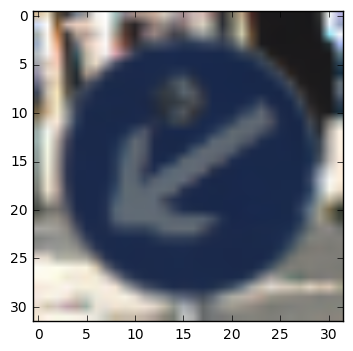

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

import numpy as np
from os.path import isfile
from collections import Counter

# Increas training data for classes less than 500 samples
augment_times = 4
def augment_data(X, y):
    counter = Counter(y)
    new_X = []
    new_y = []
    for i in range(len(y)):
        label = y[i]
        if counter[label] < 500:
            for j in range(augment_times):
                new_image = rotate_image(X[i])
                new_X.append(new_image)
                new_y.append(label)
    new_X = np.array(new_X)
    new_y = np.array(new_y)
                
    return np.array(new_X), np.array(new_y)

training_file_aug = 'train_aug.p'
testing_file_aug = 'test_aug.p'

X_aug, y_aug = None, None
if isfile(training_file_aug) and isfile(testing_file_aug):
    print('augmented data found, unpickle file ...')
    with open(training_file_aug, mode='rb') as f:
        X_aug = pickle.load(f)
    with open(testing_file_aug, mode='rb') as f:
        y_aug = pickle.load(f)
else:
    print('no augmented data found, generate new images ...')
    X_aug, y_aug = augment_data(X_train_orig, y_train_orig)
    with open(training_file_aug, mode='wb') as f:
        pickle.dump(X_aug, f)
    with open(testing_file_aug, mode='wb') as f:
        pickle.dump(y_aug, f)

print('sample augmented image')
display_sample(X_aug, y_aug)
        
# concatenate data and free up memory spaces
X_train_new = np.concatenate((X_train_orig, X_aug))
y_train_new = np.concatenate((y_train_orig, y_aug))
del X_train_orig
del X_aug
del y_train_orig
del y_aug

In [6]:
# normalize image data from ~1.0 to 1.0
def normalize(data):
    a = -0.5
    b = 0.5
    data_min = 0
    data_max = 255
    return a + (data - data_min) * (b-a) / (data_max - data_min)

X_train = normalize(X_train_new)
y_train = y_train_new
X_test = normalize(X_test_orig)
y_test = y_test_orig


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
Some steps are applied on the training data:
    1. Normalize all vectors to the same scale (-1.0~1.0) since its RGB pixels, I simply substract it by 128 and then devide it by 256.
    2. Augment training data for classes that has less than 500 samples, by rotating the image a randomly (-5~5 degree) and scale the image to fit into the 32x32 square image (to eliminate dark triangles at the corner).
    
    I normalized all features space in order to increase the speed of opimizer and avoid training biased by any features, I augmented the data sets that have less than 500 samples to avoid my network biased by probability of  occurance between different classes.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I train my network with 5-fold train/test plit (using 20% as validating) and average five results to prevent accidentally overfitting the data while tuning hyper parameters. I generated more training data (for those classes that have less than 500 samples) using openCV affine transformation. Since the rotate image was originally 32x32 image, I have to do some math and scale the image to fit 32x32 again to avoid those black regions at the corner of the generated images. Overall the generated images looks pretty much alike to the original imgaes but with a little bit of blurring effect(due to scaling process). 

data distribution after agumentation


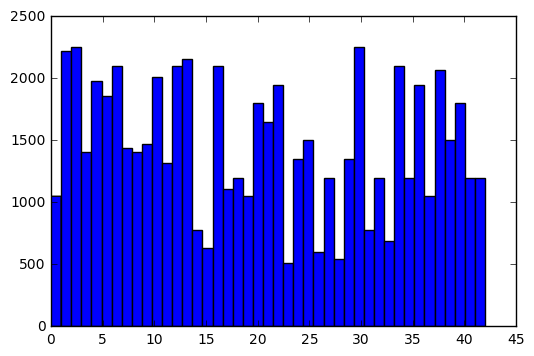

In [7]:
print('data distribution after agumentation')
show_labels_histogram(y_train_new)

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

def MyNet(x, keep_prob):
    mu = 0
    sigma = 0.01
    
    # try learn it's own color space 32*32*3 -> 32*32*3
    conv0_width = 3
    conv0_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 3, conv0_width), mean=mu, stddev=sigma), name='conv0_W')
    conv0_b = tf.Variable(tf.zeros(conv0_width), name='conv0_b')
    conv0 = tf.nn.conv2d(x, conv0_W, strides=[1, 1, 1, 1], padding='VALID')
    conv0 = tf.nn.bias_add(conv0, conv0_b)
    
    # Activation
    conv0 = tf.nn.relu(conv0)
    
    # layer 1: convolutional. 32*32*3 -> 28*28*6
    conv1_width = 6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv0_width, conv1_width), mean=mu, stddev=sigma), name='conv1_W')
    conv1_b = tf.Variable(tf.zeros(conv1_width), name='conv1_b')
    conv1 = tf.nn.conv2d(conv0, conv1_W, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, conv1_b)
    
    # Activation
    conv1 = tf.nn.relu(conv1)
    
    # Down sampling: max pooling. 28*28*6 -> 14*14*6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # layer 2: convolutional. 14*14*6 -> 10*10*16
    conv2_width = 16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv1_width, conv2_width), mean=mu, stddev=sigma), name='conv2_W')
    conv2_b = tf.Variable(tf.zeros(conv2_width), name='conv2_b')
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, conv2_b)
    
    # Activation
    conv2 = tf.nn.relu(conv2)
    
    # Down sampling: 10*10*16 -> 5*5*16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten data: 5*5*16 -> 400
    fc0 = tf.contrib.layers.flatten(conv2)
    conv_width = 5*5*conv2_width
    
    # Layer 3: fullay connected. 400 -> 120
    fc1_width = 120
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(conv_width, fc1_width), mean=mu, stddev=sigma), name='fc1_W')
    fc1_b = tf.Variable(tf.zeros(fc1_width), name='fc1_b')
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation
    fc1 = tf.nn.relu(fc1)
    
    # dropout with keep prob
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    # Layer 4: fully connected. 120 -> 90
    fc2_width = 90
    fc2_W = tf.Variable(tf.truncated_normal(shape=(fc1_width, fc2_width), mean=mu, stddev=sigma), name='fc2_W')
    fc2_b = tf.Variable(tf.zeros(fc2_width), name='fc2_b')
    fc2 = tf.matmul(fc1_drop, fc2_W) + fc2_b
    
    # Activation
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: fully connected. 90 -> 43
    fc3_W = tf.Variable(tf.truncated_normal(shape=(fc2_width, n_classes), mean=mu, stddev=sigma), name='fc3_W')
    fc3_b = tf.Variable(tf.zeros(n_classes), name='fc3_b')
    _logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return _logits

In [9]:
# Training pipeline
EPOCHS = 100
BATCH_SIZE = 128
n_classes = 43

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
tf.add_to_collection('x', x)
tf.add_to_collection('y', y)

learn_rate = tf.placeholder(tf.float32, name='learn_rate')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
one_hot_y = tf.one_hot(y, n_classes)

logits = MyNet(x, keep_prob)
tf.add_to_collection('keep_prob', keep_prob)
tf.add_to_collection('logits', logits)


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate)
training_operation = optimizer.minimize(loss_operation)

In [10]:
# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.add_to_collection('correct_prediction', correct_prediction)
tf.add_to_collection('accuracy_operation', accuracy_operation)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y,
                                keep_prob: 1.0,
                            })
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Validate parameters using k-fold (k=5)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

train_accuracy = []
test_accuracy = []

BATCH_SIZE = 128
print('Shuffling data ...')
X_train, y_train = shuffle(X_train, y_train)
print('Performing train test split')
_X_train, _X_validate, _y_train, _y_validate = train_test_split(X_train, y_train, random_state=42)    

for try_rate in (0.001, 0.001, 0.0001):
    print('start training with %f' % try_rate)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(EPOCHS):
            num_examples = len(_X_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = _X_train[offset:end], _y_train[offset:end]
                sess.run(training_operation, 
                         feed_dict={
                             x: batch_x, 
                             y: batch_y,
                             keep_prob: 0.5,
                             learn_rate: try_rate,
                         })
        
            t_acc = evaluate(_X_train, _y_train)
            v_acc = evaluate(_X_validate, _y_validate)
            train_accuracy.append(t_acc)
            test_accuracy.append(v_acc)
            print('Epoch {0},  t_acc: {1:.4f} v_acc: {2:.4f}'.format(i+1, t_acc, v_acc))

plt.subplot(211)
plt.plot(train_accuracy)
plt.subplot(212)
plt.plot(test_accuracy)

print('finished')

Shuffling data ...
Performing train test split
finished


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My finall network is a modified version of LeNet5 starting with 2 convolution layer followed by 3 fully connected layer with a regularization(propout) between the first and second fully connected layers. layers are described as following.

1. Convolution layer with 5x5x3 filter and VALID padding causing the volume to reducing from 32x32x3 (input image samples) to 28x28x6.
2. Max pooling: 2x2 max polling with 2, 2 stride down sampling the image from 28x28x6 to 14x14x6
3. Convolution layer with 5x5 filter plus VALUD padding making the size from 14x14x6 into 10x10x16
4. Max pooling: Another 2x2 max pooling with 2,2 stride. valume: 10x10x16 -> 5x5x16
5. Flatten data: flatten 5x5x16 data into 1D vector 1x400
6. Fully connected layer multiply by a 400x120 variable matrix making the data from 1x400 to 1x120
7. Activation function: I use relu here.
8. Drop-out with 50% keep probability to prevent overfitting and.
9. Another fully connected layer: 1x120->1x84
10. Last fully connected layer converting data to classes 1x84->1x43

Also to avoid overfitting:

1. use L2 regularization with beta = 0.001
2. dropout with keep_prod 0.5


In [12]:
# Finally train the model on full dataset and evaluate on test dataset

train_accuracy = []
saver = tf.train.Saver()
BATCH_SIZE = 128
LEARN_RATE = 0.001
EPOCHS = 150

with tf.Session() as sess:
    print('Start training on full dataset ...')
    sess.run(tf.global_variables_initializer())
    for i in range(EPOCHS):
        num_examples = len(X_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, 
                     feed_dict={
                         x: batch_x, 
                         y: batch_y,
                         keep_prob: 0.5,
                         learn_rate: LEARN_RATE,
                     })

        t_acc = evaluate(X_train, y_train)
        v_acc = evaluate(X_test, y_test)
        train_accuracy.append(t_acc)
        if (i+1) % 10 == 0:
            print('Epoch {0},  train accuracy: {1:.4f}, test accuracy: {2:.4f}'.format(i+1, t_acc, v_acc))
            saved_path = saver.save(sess, './checkpoints/full-traindata', global_step=i+1)
            print('session saved under %s' % saved_path)

Start training on full dataset ...
Epoch 10,  train accuracy: 0.7976, test accuracy: 0.6470
session saved under ./checkpoints/full-traindata-10
Epoch 20,  train accuracy: 0.8801, test accuracy: 0.7513
session saved under ./checkpoints/full-traindata-20
Epoch 30,  train accuracy: 0.9320, test accuracy: 0.8187
session saved under ./checkpoints/full-traindata-30
Epoch 40,  train accuracy: 0.9530, test accuracy: 0.8603
session saved under ./checkpoints/full-traindata-40
Epoch 50,  train accuracy: 0.9650, test accuracy: 0.8809
session saved under ./checkpoints/full-traindata-50
Epoch 60,  train accuracy: 0.9735, test accuracy: 0.8954
session saved under ./checkpoints/full-traindata-60
Epoch 70,  train accuracy: 0.9761, test accuracy: 0.8949
session saved under ./checkpoints/full-traindata-70
Epoch 80,  train accuracy: 0.9783, test accuracy: 0.9035
session saved under ./checkpoints/full-traindata-80
Epoch 90,  train accuracy: 0.9831, test accuracy: 0.9066
session saved under ./checkpoints/fu

start plotting ...


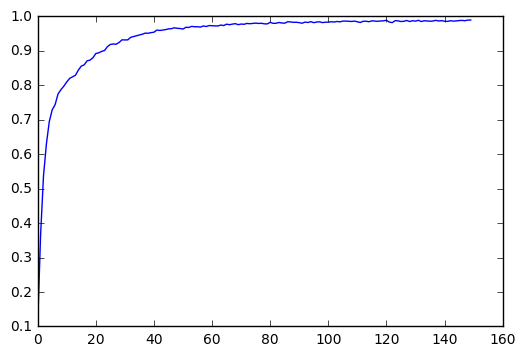

In [13]:
print('start plotting ...')
plt.plot(train_accuracy)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

* EPOCHS = 100 (while tuning hyper params) and 150 when training on full dataset
* Batch size: 128
* Learning_rate = 0.001
* Optimizer = Adam
* Initialized placeholder with truncated normal (mu = 0, sigma = 0.01)

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Startting with a LeNet5, I tried to train the dataset with 20% test splits. First few attemps I easily got a greate accuracy on the 20% test data (0.992) so I tried it on the validating dataset but the accuracy drops seriously(0.92).
After some investication on the validating data sets, I came up with 2 possible reasons for the accuracy drop.
1. My model is overfitting the training data.
2. The testing data is larger than my 20% testing dataset.
So I added a dropout layer (50% keep_prob) and tried different hyper parameters to get the best results.

** Different learning rate for 100 EPOCHS **

| learning rate | 20% test accuracy | result |
|---------|--------|---------|
| 0.01    | 0.0325 | don't converge
| 0.005   | 0.9522 | - |
| 0.001   | 0.9757 | best |
| 0.0005  | 0.9681 | - |
| 0.0001  | 0.5762 | might need more EPOCHS |

** Different batch size with 100 EPOCHS **

| batch size | 20% test accuracy | result |
|---------|--------|---------|
| 64    | 0.9680 | - |
| 128   | 0.9861 | best |
| 256   | 0.9729 | - |
| 512   | 0.9691 | - |

Finally I decided to go with `learn_rate = 0.001` and `batch_size = 128` and train on full training dataset, and managed to got 0.94 accuracy on the testing dataset.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

label 22
origin image shape: (120, 120, 3)


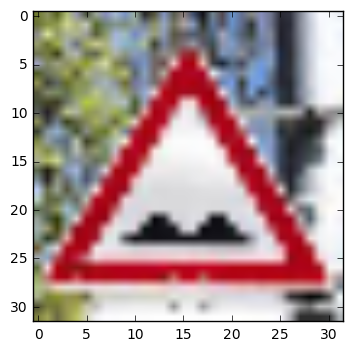

label 18
origin image shape: (216, 216, 3)


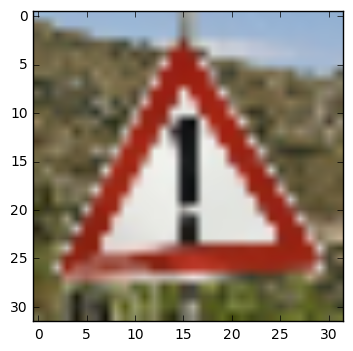

label 27
origin image shape: (803, 803, 3)


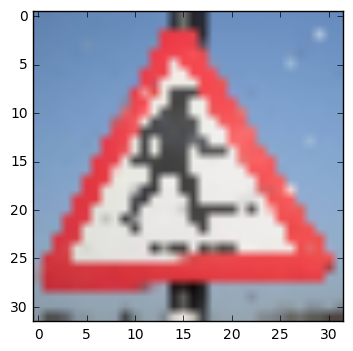

label 25
origin image shape: (50, 50, 3)


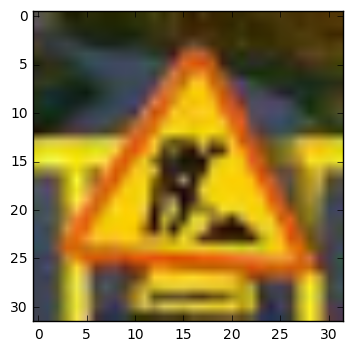

label 14
origin image shape: (1065, 1065, 3)


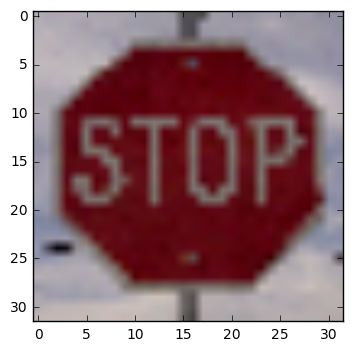

done


In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

from os.path import isfile
import cv2
import matplotlib.pyplot as plt

%matplotlib inline


new_images = [
    ('./web_images/bumpy_square.png', 22),
    ('./web_images/danger_square.png', 18),
    ('./web_images/pedestrians_square.png', 27),
    ('./web_images/road_work_square.png', 25),
    ('./web_images/stop_square.png', 14),
]

new_images_data = []
new_labels_data = []

def show_image(file_path):
    if isfile(file_path):
        imgBGR = cv2.imread(file_path)
        imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
        print('origin image shape:', imgRGB.shape)
        imgResize = cv2.resize(imgRGB, (32, 32))
        plt.imshow(imgResize)
        plt.show()
    else:
        print('no such file %s' % image_name)
    img_ = np.copy(imgResize)
    return img_
        
for img_path, label in new_images:
    print('label %d' % label)
    img_data = show_image(img_path)
    new_images_data.append(normalize(img_data))
    new_labels_data.append(label)
        
print('done')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
for really high resolution images (e.g. 3rd (803x803) and 5th (1065x1065) ), the image become quite zigzap after `cv2.Resize`, I think this might make the classifier harder to clasiify correctly  

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
soft_max_logits = None

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('checkpoints/full-traindata-150.meta')
    new_saver.restore(sess, 'checkpoints/full-traindata-150')
    print('model restored')
    
    accuracy_operation = tf.get_collection('accuracy_operation')[0]
    x = tf.get_collection('x')[0]
    y = tf.get_collection('y')[0]
    keep_prob = tf.get_collection('keep_prob')[0]
    
    predictions = sess.run(accuracy_operation, feed_dict={
        x: new_images_data, 
        y: new_labels_data,
        keep_prob: 1.0,
    })      
    print('Predictions:', predictions)


model restored
Predictions: 0.8


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The result of my prediction is 80% (4 out of 5)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [16]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [24]:
top_k = None

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('checkpoints/full-traindata-150.meta')
    new_saver.restore(sess, 'checkpoints/full-traindata-150')
    print('model restored')

    accuracy_operation = tf.get_collection('accuracy_operation')[0]
    x = tf.get_collection('x')[0]
    y = tf.get_collection('y')[0]
    logits = tf.get_collection('logits')[0]
    
    _logits = sess.run(logits, feed_dict={
        x: new_images_data, 
        y: new_labels_data,
        keep_prob: 1.0,
    })
    soft_max_logits = tf.nn.softmax(_logits)
    print(soft_max_logits)
    top_k = sess.run(tf.nn.top_k(soft_max_logits, k=5))
    print('top_k', top_k)
    print(new_labels_data)
 

model restored
Tensor("Softmax_4:0", shape=(5, 43), dtype=float32)
top_k TopKV2(values=array([[  1.00000000e+00,   9.33327993e-09,   2.68645578e-10,
          1.66677672e-10,   9.63036664e-11],
       [  9.99998927e-01,   8.71862653e-07,   2.32459982e-07,
          7.13909332e-09,   8.52500308e-13],
       [  9.84807611e-01,   6.81261998e-03,   3.43603268e-03,
          2.57184543e-03,   2.27495702e-03],
       [  9.39089119e-01,   5.45025952e-02,   3.19441943e-03,
          1.54539803e-03,   9.68476292e-04],
       [  8.71686041e-01,   8.76294225e-02,   1.23850619e-02,
          7.08558830e-03,   5.38961124e-03]], dtype=float32), indices=array([[22, 34, 12, 25, 23],
       [18, 26, 34, 40, 11],
       [40,  7, 10, 31,  8],
       [25,  3, 42, 41, 20],
       [14,  8, 15,  2,  7]], dtype=int32))
[22, 18, 27, 25, 14]


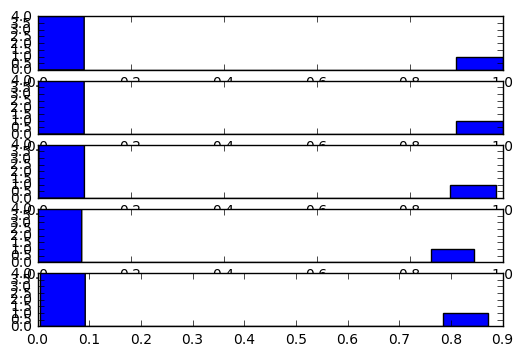

In [29]:
import matplotlib.pyplot as plt
   
for i in range(5):    
    plt.subplot(5, 1, i+1)
    plt.hist(top_k.values[i])


**Answer:**
My model was quite sure about all images, though the 3rd one was predicted incorreclty

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.